DATASET CT BRAIN DRIVE


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

# Ganti 'Nama_Shortcut_Folder' dengan nama folder yang tadi kamu tambahkan ke My Drive
DATA_DIRECTORY = "/content/drive/MyDrive/CT Brain Data"

# Cek isinya untuk memastikan
if os.path.exists(DATA_DIRECTORY):
    print("✅ Folder ditemukan!")
    print("Isi file:", os.listdir(DATA_DIRECTORY)[:5])
else:
    print("❌ Folder belum ditemukan. Pastikan sudah buat shortcut di My Drive.")

✅ Folder ditemukan!
Isi file: ['CT_', 'CT_2', 'CT_3', 'CTC_', 'CTC_2']


DAATASET BRATS20 DOWNLOAD

In [ ]:
import os

# 1. Setup API Key
os.environ["KAGGLE_USERNAME"] = "muhammadaliffandy"
os.environ["KAGGLE_KEY"] = "KGAT_6cf20e173408038efc8c307643a53392"

# 2. Install kagglehub
!pip install -q kagglehub

import kagglehub

print("⏳ Memulai download dataset BraTS2020...")
# Download (ini akan masuk ke cache dulu)
download_path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print(f"✅ Download selesai di: {download_path}")

# 3. Pindahkan secara paksa menggunakan perintah terminal (Linux cp)
# Kita pakai -r (recursive) untuk copy folder dan isinya
print("🚚 Memindahkan folder ke /content agar lebih mudah diakses...")

!cp -r "{download_path}/BraTS2020_TrainingData" /content/
!cp -r "{download_path}/BraTS2020_ValidationData" /content/

# 4. Verifikasi Akhir
if os.path.exists("/content/BraTS2020_TrainingData"):
    print("\n✨ BERHASIL! Sekarang dataset kamu ada di:")
    print("👉 Training: /content/BraTS2020_TrainingData")
    print("👉 Validation: /content/BraTS2020_ValidationData")
    print("\nIsi 5 folder training pertama:", os.listdir("/content/BraTS2020_TrainingData")[:5])
else:
    print("\n❌ Masih gagal memindahkan. Coba cek sisa penyimpanan (Disk) Colab kamu.")

⏳ Memulai download dataset BraTS2020...
Using Colab cache for faster access to the 'brats20-dataset-training-validation' dataset.
✅ Download selesai di: /kaggle/input/brats20-dataset-training-validation
🚚 Memindahkan folder ke /content agar lebih mudah diakses...

✨ BERHASIL! Sekarang dataset kamu ada di:
👉 Training: /content/BraTS2020_TrainingData
👉 Validation: /content/BraTS2020_ValidationData

Isi 5 folder training pertama: ['MICCAI_BraTS2020_TrainingData']


In [1]:
# 1. Hapus versi torch bawaan Colab agar tidak bentrok
!pip install escnn

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import os
import traceback

# Pustaka khusus untuk E2CNN
from escnn import gspaces
import escnn.nn as enn

CT BRAIN DATASET LOADER

In [2]:
class CTMultiFolderDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []

        # Daftar sub-folder yang ingin diambil (CT_, CT_2, dll)
        sub_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]

        print("🔍 Mulai menyisir data di semua folder...")

        for folder in sub_folders:
            folder_path = os.path.join(root_dir, folder)
            # Ambil semua file citra asli (bukan mask)
            images = sorted([f for f in os.listdir(folder_path) if f.endswith('.nii.gz') and '.seg.' not in f])

            for img_name in images:
                mask_name = img_name.replace('.nii.gz', '.seg.nii.gz')
                img_full_path = os.path.join(folder_path, img_name)
                mask_full_path = os.path.join(folder_path, mask_name)

                # Hanya masukkan jika pasangan mask-nya ada
                if os.path.exists(mask_full_path):
                    self.samples.append((img_full_path, mask_full_path))

        print(f"✅ Total ditemukan {len(self.samples)} pasangan data dari {len(sub_folders)} folder.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
      img_path, mask_path = self.samples[idx]
      image = nib.load(img_path).get_fdata()
      mask = nib.load(mask_path).get_fdata()

      mid = image.shape[2] // 2
      img_slice = image[:, :, mid]
      mask_slice = mask[:, :, mid]

      img_tensor = torch.tensor(img_slice, dtype=torch.float32).unsqueeze(0) # [1, H, W]
      mask_tensor = torch.tensor(mask_slice, dtype=torch.long).unsqueeze(0).unsqueeze(0) # [1, 1, H, W]

      # --- RESIZE DI SINI ---
      img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(256, 256), mode='bilinear').squeeze(0).squeeze(0).unsqueeze(0)
      mask_tensor = F.interpolate(mask_tensor.float(), size=(256, 256), mode='nearest').long().squeeze()
      # ----------------------

      if img_tensor.max() > img_tensor.min():
          img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())

      return img_tensor, mask_tensor

BRATSDATASET2D DATASET LOADER

In [ ]:
class BraTSDataset2D(Dataset):
    def __init__(self, data_dir):
        self.base_path = data_dir
        all_dirs = sorted([p for p in os.listdir(self.base_path)
                          if os.path.isdir(os.path.join(self.base_path, p))])

        self.patient_dirs = []
        print("🔍 Memverifikasi kelengkapan file pasien...")

        for p in all_dirs:
            p_path = os.path.join(self.base_path, p)
            # Cek apakah 5 file wajib ada (cek .nii atau .nii.gz)
            required_files = ['flair', 't1', 't1ce', 't2', 'seg']
            is_complete = True

            for suffix in required_files:
                f_path = os.path.join(p_path, f"{p}_{suffix}.nii")
                if not (os.path.exists(f_path) or os.path.exists(f_path + ".gz")):
                    is_complete = False
                    break

            if is_complete:
                self.patient_dirs.append(p)
            else:
                print(f"⚠️ Skip Pasien {p}: File tidak lengkap.")

        print(f"✅ Siap! Menggunakan {len(self.patient_dirs)} pasien dari total {len(all_dirs)}.")

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir_name = self.patient_dirs[idx]
        patient_path = os.path.join(self.base_path, patient_dir_name)

        # Fungsi helper untuk load data agar tidak repetitif
        def load_nifti(file_suffix):
            path = os.path.join(patient_path, f"{patient_dir_name}_{file_suffix}.nii")
            # Cek apakah file ada, jika tidak coba tambahkan .gz (antisipasi kompresi)
            if not os.path.exists(path):
                path += ".gz"
            return nib.load(path).get_fdata()

        # Memuat data citra
        flair_img = load_nifti("flair")
        t1_img = load_nifti("t1")
        t1ce_img = load_nifti("t1ce")
        t2_img = load_nifti("t2")
        seg_mask = load_nifti("seg")

        # Slice tengah
        mid_slice_idx = flair_img.shape[2] // 2

        image_stack = np.stack([
            flair_img[:, :, mid_slice_idx],
            t1_img[:, :, mid_slice_idx],
            t1ce_img[:, :, mid_slice_idx],
            t2_img[:, :, mid_slice_idx]
        ], axis=0)

        seg_slice = seg_mask[:, :, mid_slice_idx]

        # Konversi ke tensor PyTorch
        image_tensor = torch.tensor(image_stack, dtype=torch.float32)
        label_tensor = torch.tensor(seg_slice, dtype=torch.long)

        # Mapping label 4 (Enhancing Tumor) ke 3 (agar sekuensial 0,1,2,3)
        label_tensor[label_tensor == 4] = 3

        # Normalisasi Min-Max Sederhana
        for i in range(image_tensor.shape[0]):
            max_val = image_tensor[i].max()
            min_val = image_tensor[i].min()
            if max_val > min_val:
                image_tensor[i] = (image_tensor[i] - min_val) / (max_val - min_val)

        return image_tensor, label_tensor

In [3]:
class DoubleEquivariantConv(nn.Module):
    """Blok konvolusi ganda yang equivariant."""
    def __init__(self, in_type, out_type, mid_type=None):
        super().__init__()
        if not mid_type:
            mid_type = out_type
        self.double_conv = enn.SequentialModule(
            enn.R2Conv(in_type, mid_type, kernel_size=3, padding=1, bias=False),
            enn.InnerBatchNorm(mid_type),
            enn.ReLU(mid_type, inplace=True),
            enn.R2Conv(mid_type, out_type, kernel_size=3, padding=1, bias=False),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type, inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Blok downsampling menggunakan MaxPool diikuti DoubleEquivariantConv."""
    def __init__(self, in_type, out_type):
        super().__init__()
        self.pool = enn.PointwiseMaxPool(in_type, kernel_size=2)
        self.conv = DoubleEquivariantConv(in_type, out_type)
    def forward(self, x):
        x = self.pool(x)
        return self.conv(x)

class Up(nn.Module):
    """Blok upsampling diikuti penggabungan skip connection dan DoubleEquivariantConv."""
    def __init__(self, in_type, out_type):
        super().__init__()
        self.up = enn.R2Upsampling(in_type, scale_factor=2, mode='bilinear', align_corners=True)
        # Tipe input untuk konvolusi adalah gabungan dari tensor setelah upsampling dan tensor dari skip connection
        self.conv = DoubleEquivariantConv(in_type + out_type, out_type)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Menggabungkan tensor dari skip connection (x2) dan tensor yang di-upsample (x1)
        x = enn.tensor_directsum([x2, x1])
        return self.conv(x)

class OutConv(nn.Module):
    """Konvolusi 1x1 di akhir untuk memetakan fitur ke jumlah kelas output."""
    def __init__(self, in_type, n_classes):
        super().__init__()
        gspace = in_type.gspace
        # Tipe output adalah trivial representation, karena output segmentasi harus invarian terhadap rotasi
        out_type = enn.FieldType(gspace, n_classes * [gspace.trivial_repr])
        self.conv = enn.R2Conv(in_type, out_type, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class SE2_CNNET(nn.Module):
    """
    Arsitektur U-Net Equivariant SE(2) untuk segmentasi.
    N: Jumlah rotasi diskrit yang akan dipertimbangkan (misal, N=8 untuk rotasi kelipatan 45 derajat).
    base_channels: Jumlah channel dasar pada lapisan pertama.
    """
    def __init__(self, n_channels, n_classes, N=8, base_channels=24):
        super().__init__()
        self.r2_act = gspaces.rot2dOnR2(N=N)
        c = base_channels

        # Mendefinisikan tipe field untuk setiap level kedalaman U-Net
        self.feat_type_in = enn.FieldType(self.r2_act, n_channels * [self.r2_act.trivial_repr])
        self.feat_type_1 = enn.FieldType(self.r2_act, c * [self.r2_act.regular_repr])
        self.feat_type_2 = enn.FieldType(self.r2_act, (c*2) * [self.r2_act.regular_repr])
        self.feat_type_3 = enn.FieldType(self.r2_act, (c*4) * [self.r2_act.regular_repr])
        self.feat_type_4 = enn.FieldType(self.r2_act, (c*8) * [self.r2_act.regular_repr])
        self.feat_type_5 = enn.FieldType(self.r2_act, (c*16) * [self.r2_act.regular_repr])

        # Encoder Path
        self.inc = DoubleEquivariantConv(self.feat_type_in, self.feat_type_1)
        self.down1 = Down(self.feat_type_1, self.feat_type_2)
        self.down2 = Down(self.feat_type_2, self.feat_type_3)
        self.down3 = Down(self.feat_type_3, self.feat_type_4)
        self.down4 = Down(self.feat_type_4, self.feat_type_5)

        # Decoder Path
        self.up1 = Up(self.feat_type_5, self.feat_type_4)
        self.up2 = Up(self.feat_type_4, self.feat_type_3)
        self.up3 = Up(self.feat_type_3, self.feat_type_2)
        self.up4 = Up(self.feat_type_2, self.feat_type_1)

        # Output Layer
        self.outc = OutConv(self.feat_type_1, n_classes)

    def forward(self, x):
        # Konversi input tensor menjadi GeometricTensor
        x_geom = enn.GeometricTensor(x, self.feat_type_in)

        # Encoder
        x1 = self.inc(x_geom)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Mengembalikan tensor biasa untuk dihitung loss-nya
        logits = self.outc(x).tensor
        return logits


In [ ]:
def run_test():
    """
    Fungsi untuk menjalankan tes singkat pada dataset dan model.
    """
    try:
        print("Menjalankan uji coba model dan data loader...")
        DATA_DIRECTORY = r"/root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1/BraTS2020_TrainingData"
        train_dataset = BraTSDataset2D(data_dir=DATA_DIRECTORY)
        single_image, _ = train_dataset[0]

        # device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
        device = 'cpu'
        print(device)

        model = SE2_CNNET(n_channels=4, n_classes=4).to(device)

        # Menambahkan dimensi batch
        input_tensor = single_image.unsqueeze(0).to(device)

        print(f"Menggunakan device: {device}")
        print(f"Bentuk input tensor: {input_tensor.shape}")

        model.eval()
        with torch.no_grad():
            output = model(input_tensor)

        print(f"Bentuk output tensor: {output.shape}")
        print("\nProses SE2-CNN selesai tanpa error.")

    except Exception as e:
        print(f"\nTerjadi error: {e}")
        traceback.print_exc()

run_test()

Menjalankan uji coba model dan data loader...
cpu


/usr/local/lib/python3.12/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:37.)
  full_mask[mask] = norms.to(torch.uint8)


KeyboardInterrupt: 

CT BRAIN DATASET INITIATION


In [6]:
# Jalur ke folder utama yang isinya CT_, CT_2, dsb.
ROOT_DATA_PATH = "/content/drive/MyDrive/CT Brain Data"

# Inisialisasi Dataset
full_dataset = CTMultiFolderDataset(root_dir=ROOT_DATA_PATH)

# Bungkus ke DataLoader untuk Training
from torch.utils.data import DataLoader
train_loader = DataLoader(full_dataset, batch_size=4, shuffle=True)

# Tes ambil satu batch
images, masks = next(iter(train_loader))
print(f"✅ Batch siap! Bentuk Batch Image: {images.shape}") # [4, 1, H, W]

🔍 Mulai menyisir data di semua folder...
✅ Total ditemukan 7999 pasangan data dari 6 folder.
✅ Batch siap! Bentuk Batch Image: torch.Size([4, 1, 512, 512])


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# 1. Update Path & Parameter
ROOT_DATA_PATH = "/content/drive/MyDrive/CT Brain Data"
LEARNING_RATE = 1e-4
BATCH_SIZE = 4      # Jika nanti Cuda Out of Memory, turunkan ke 2
EPOCHS = 10
VALIDATION_SPLIT = 0.15
NUM_CLASSES = 2     # CT Scan kamu biasanya 2 (0: Background, 1: Target)
INPUT_CHANNELS = 1  # WAJIB 1 untuk CT Scan

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 2. Ganti Dataset Loader ke CTMultiFolderDataset
print("Mempersiapkan dataset CT Scan Multi-Folder...")
full_dataset = CTMultiFolderDataset(root_dir=ROOT_DATA_PATH)

# Split Data
n_val = int(len(full_dataset) * VALIDATION_SPLIT)
n_train = len(full_dataset) - n_val
train_set, val_set = random_split(full_dataset, [n_train, n_val])

# Data Loader (pin_memory=True sangat membantu kecepatan di Colab)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"Data siap: {len(train_set)} training, {len(val_set)} validasi.")

# 3. Inisialisasi Model dengan 1 Channel
model = SE2_CNNET(n_channels=INPUT_CHANNELS, n_classes=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Device: cuda
Mempersiapkan dataset CT Scan Multi-Folder...
🔍 Mulai menyisir data di semua folder...
✅ Total ditemukan 7999 pasangan data dari 6 folder.
Data siap: 6800 training, 1199 validasi.


In [ ]:
from torch.cuda.amp import autocast, GradScaler

# Inisialisasi Scaler untuk Mixed Precision (FP16)
scaler = GradScaler()
ACCUMULATION_STEPS = 8  # Update bobot setiap 8 batch (Batch efektif = 8)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for i, (images, labels) in enumerate(pbar_train):
        images, labels = images.to(device), labels.to(device)

        # 1. Forward pass dengan Autocast (Hemat VRAM)
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / ACCUMULATION_STEPS # Normalisasi loss

        # 2. Backward pass dengan Scaler
        scaler.scale(loss).backward()

        # 3. Step hanya setelah akumulasi terpenuhi
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * ACCUMULATION_STEPS
        pbar_train.set_postfix({'loss': loss.item() * ACCUMULATION_STEPS})

        # Bersihkan variabel agar VRAM tidak menumpuk
        del outputs, loss

    avg_train_loss = running_loss / len(train_loader)

    # --- VALIDASI ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validasi]")
        for images, labels in pbar_val:
            images, labels = images.to(device), labels.to(device)

            with autocast(): # Tetap pakai autocast di validasi agar cepat
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            pbar_val.set_postfix({'val_loss': loss.item()})
            del outputs, loss

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Simpan model ke file
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

    # Paksa GPU buang sampah tiap ganti epoch
    torch.cuda.empty_cache()

/tmp/ipython-input-4238295420.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10 [Training]:   0%|          | 0/1700 [00:00<?, ?it/s]/tmp/ipython-input-4238295420.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Training]:   0%|          | 1/1700 [00:19<9:13:52, 19.56s/it, loss=0.189]/tmp/ipython-input-4238295420.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Training]:   0%|          | 2/1700 [00:37<8:46:31, 18.61s/it, loss=0.192]/tmp/ipython-input-4238295420.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Training]:   0%|          | 3/1

# Check Arsitektur pipline Data -> Model SYNC

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

DATA_DIRECTORY = r"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
EPOCHS = 10
VALIDATION_SPLIT = 0.15 # 15% data untuk validasi
NUM_CLASSES = 4 # ET, TC, WT, dan background
INPUT_CHANNELS = 4

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device yang akan digunakan: {device}")


print("Mempersiapkan dataset...")
full_dataset = BraTSDataset2D(data_dir=DATA_DIRECTORY)

n_val = int(len(full_dataset) * VALIDATION_SPLIT)
n_train = len(full_dataset) - n_val
train_set, val_set = random_split(full_dataset, [n_train, n_val])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
print(f"Data siap: {len(train_set)} sampel training, {len(val_set)} sampel validasi.")

model = SE2_CNNET(n_channels=INPUT_CHANNELS, n_classes=NUM_CLASSES)

if torch.cuda.device_count() > 1:
    print(f"Menggunakan {torch.cuda.device_count()} GPU dengan DataParallel.")
    model = nn.DataParallel(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Device yang akan digunakan: cuda
Mempersiapkan dataset...
🔍 Memverifikasi kelengkapan file pasien...
⚠️ Skip Pasien BraTS20_Training_355: File tidak lengkap.
✅ Siap! Menggunakan 368 pasien dari total 369.
Data siap: 313 sampel training, 55 sampel validasi.


In [13]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for images, labels in pbar_train:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validasi]")
        for images, labels in pbar_val:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            pbar_val.set_postfix({'val_loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

Epoch 1/10 [Training]:   0%|          | 0/1700 [00:18<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 14.56 GiB of which 7.81 MiB is free. Including non-PyTorch memory, this process has 14.55 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 163.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import numpy as np # Diperlukan untuk float('inf')

patience = 6
epochs_no_improve = 0
best_val_loss = float('inf')
# Path untuk menyimpan model terbaik.
BEST_MODEL_PATH = '[1]best_model.pth'
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for images, labels in pbar_train:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validasi]")
        for images, labels in pbar_val:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            pbar_val.set_postfix({'val_loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


    if avg_val_loss < best_val_loss:
        print(f"Validation loss membaik ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Menyimpan model ke {BEST_MODEL_PATH}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, BEST_MODEL_PATH)
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation loss tidak membaik. Counter kesabaran: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"Early stopping! Tidak ada perbaikan selama {patience} epoch.")
        break

Epoch 1/30 [Training]:  92%|█████████▏| 73/79 [04:46<00:23,  3.92s/it, loss=0.182]


FileNotFoundError: No such file or no access: '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'

# Kalau mau async training

In [ ]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SE2_CNNET(n_channels=4, n_classes=NUM_CLASSES).to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# # Variabel untuk Melanjutkan Training ya kak
# start_epoch = 2
# best_val_loss = float('inf')
# CHECKPOINT_PATH = BEST_MODEL_PATH

# if os.path.exists(CHECKPOINT_PATH):
#     print(f"Menemukan checkpoint. Memuat dari {CHECKPOINT_PATH}...")
#     checkpoint = torch.load(CHECKPOINT_PATH)

#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1
#     best_val_loss = checkpoint['best_val_loss']
#     print(f"Checkpoint berhasil dimuat. Melanjutkan dari epoch {start_epoch}.")
# else:
#     print("Tidak ada checkpoint ditemukan. Memulai training dari awal.")

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

MODEL_PATH = 'model_epoch_1.pth'
DATA_DIRECTORY = r"BraTS2020_TrainingData"
BATCH_SIZE = 8
NUM_CLASSES = 4 # 0: background, 1: class 1, 2: class 2, 3: class 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ingat, label 4 di data asli kita petakan ke 3
CLASS_LABELS = {
    0: "Background",
    1: "NCR/NET",  # Necrotic and non-enhancing tumor core
    2: "ED",       # Peritumoral edema
    3: "ET"        # GD-enhancing tumor (sebelumnya label 4)
}

#Load Model
print(f"Memuat model dari: {MODEL_PATH}")
model = SE2_CNNET(n_channels=4, n_classes=NUM_CLASSES)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# 3model disimpan dengan nn.DataParallel
if list(state_dict.keys())[0].startswith('module.'):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # hapus `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
else:
    model.load_state_dict(state_dict)

model.to(DEVICE)
model.eval()
print("Model berhasil dimuat.")

Memuat model dari: model_epoch_1.pth
Model berhasil dimuat.


In [ ]:
def calculate_dice_iou(preds, labels, num_classes, smooth=1e-6):
    """
    Menghitung Dice Coefficient dan IoU per kelas.
    - preds: Tensor prediksi setelah argmax, shape (N, H, W)
    - labels: Tensor ground truth, shape (N, H, W)
    - num_classes: Jumlah kelas
    """
    dice_scores = np.zeros(num_classes)
    iou_scores = np.zeros(num_classes)

    # CPU dan NumPy untuk perhitungan
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    for c in range(num_classes):
        pred_mask = (preds == c)
        true_mask = (labels == c)

        intersection = np.sum(pred_mask & true_mask)
        union = np.sum(pred_mask | true_mask)

        # Dice Score
        dice = (2. * intersection + smooth) / (np.sum(pred_mask) + np.sum(true_mask) + smooth)
        dice_scores[c] = dice

        # IoU Score
        iou = (intersection + smooth) / (union + smooth)
        iou_scores[c] = iou

    return dice_scores, iou_scores

def evaluate_model(model, loader, device, num_classes):
    """
    Fungsi utama untuk menjalankan loop evaluasi.
    """
    total_dice_scores = np.zeros(num_classes)
    total_iou_scores = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad(): # Skip calculation gradient on backprop
        pbar = tqdm(loader, desc="Mengevaluasi")
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # logits menjadi prediksi kelas (0, 1, 2, atau 3)
            # torch.argmax => collect kelas dengan probabilitas tertinggi
            preds = torch.argmax(outputs, dim=1)

            dice, iou = calculate_dice_iou(preds, labels, num_classes)

            total_dice_scores += dice
            total_iou_scores += iou
            num_batches += 1

            # Tampilkan rata-rata sementara di progress bar
            mean_dice = np.mean(total_dice_scores / num_batches)
            pbar.set_postfix({'Mean Dice (avg)': f'{mean_dice:.4f}'})

    # Hitung rata-rata akhir
    avg_dice_scores = total_dice_scores / num_batches
    avg_iou_scores = total_iou_scores / num_batches

    return avg_dice_scores, avg_iou_scores


avg_dice, avg_iou = evaluate_model(model, val_loader, DEVICE, NUM_CLASSES)

print("\nHasil Evaluasi Performa")
print(f"{'Kelas':<20} | {'Dice Score':<15} | {'IoU (Jaccard)':<15}")
print("-" * 55)
for c in range(NUM_CLASSES):
    class_name = CLASS_LABELS.get(c, f"Kelas {c}")
    print(f"{class_name:<20} | {avg_dice[c]:<15.4f} | {avg_iou[c]:<15.4f}")

print("-" * 55)
print(f"{'Rata-rata (Mean)':<20} | {np.mean(avg_dice):<15.4f} | {np.mean(avg_iou):<15.4f}")
print("-" * 55)

Mengevaluasi: 100%|██████████| 14/14 [02:31<00:00, 10.85s/it, Mean Dice (avg)=0.5835]


Hasil Evaluasi Performa
Kelas                | Dice Score      | IoU (Jaccard)  
-------------------------------------------------------
Background           | 0.9940          | 0.9880         
NCR/NET              | 0.3201          | 0.2212         
ED                   | 0.5250          | 0.3679         
ET                   | 0.4947          | 0.3560         
-------------------------------------------------------
Rata-rata (Mean)     | 0.5835          | 0.4833         
-------------------------------------------------------


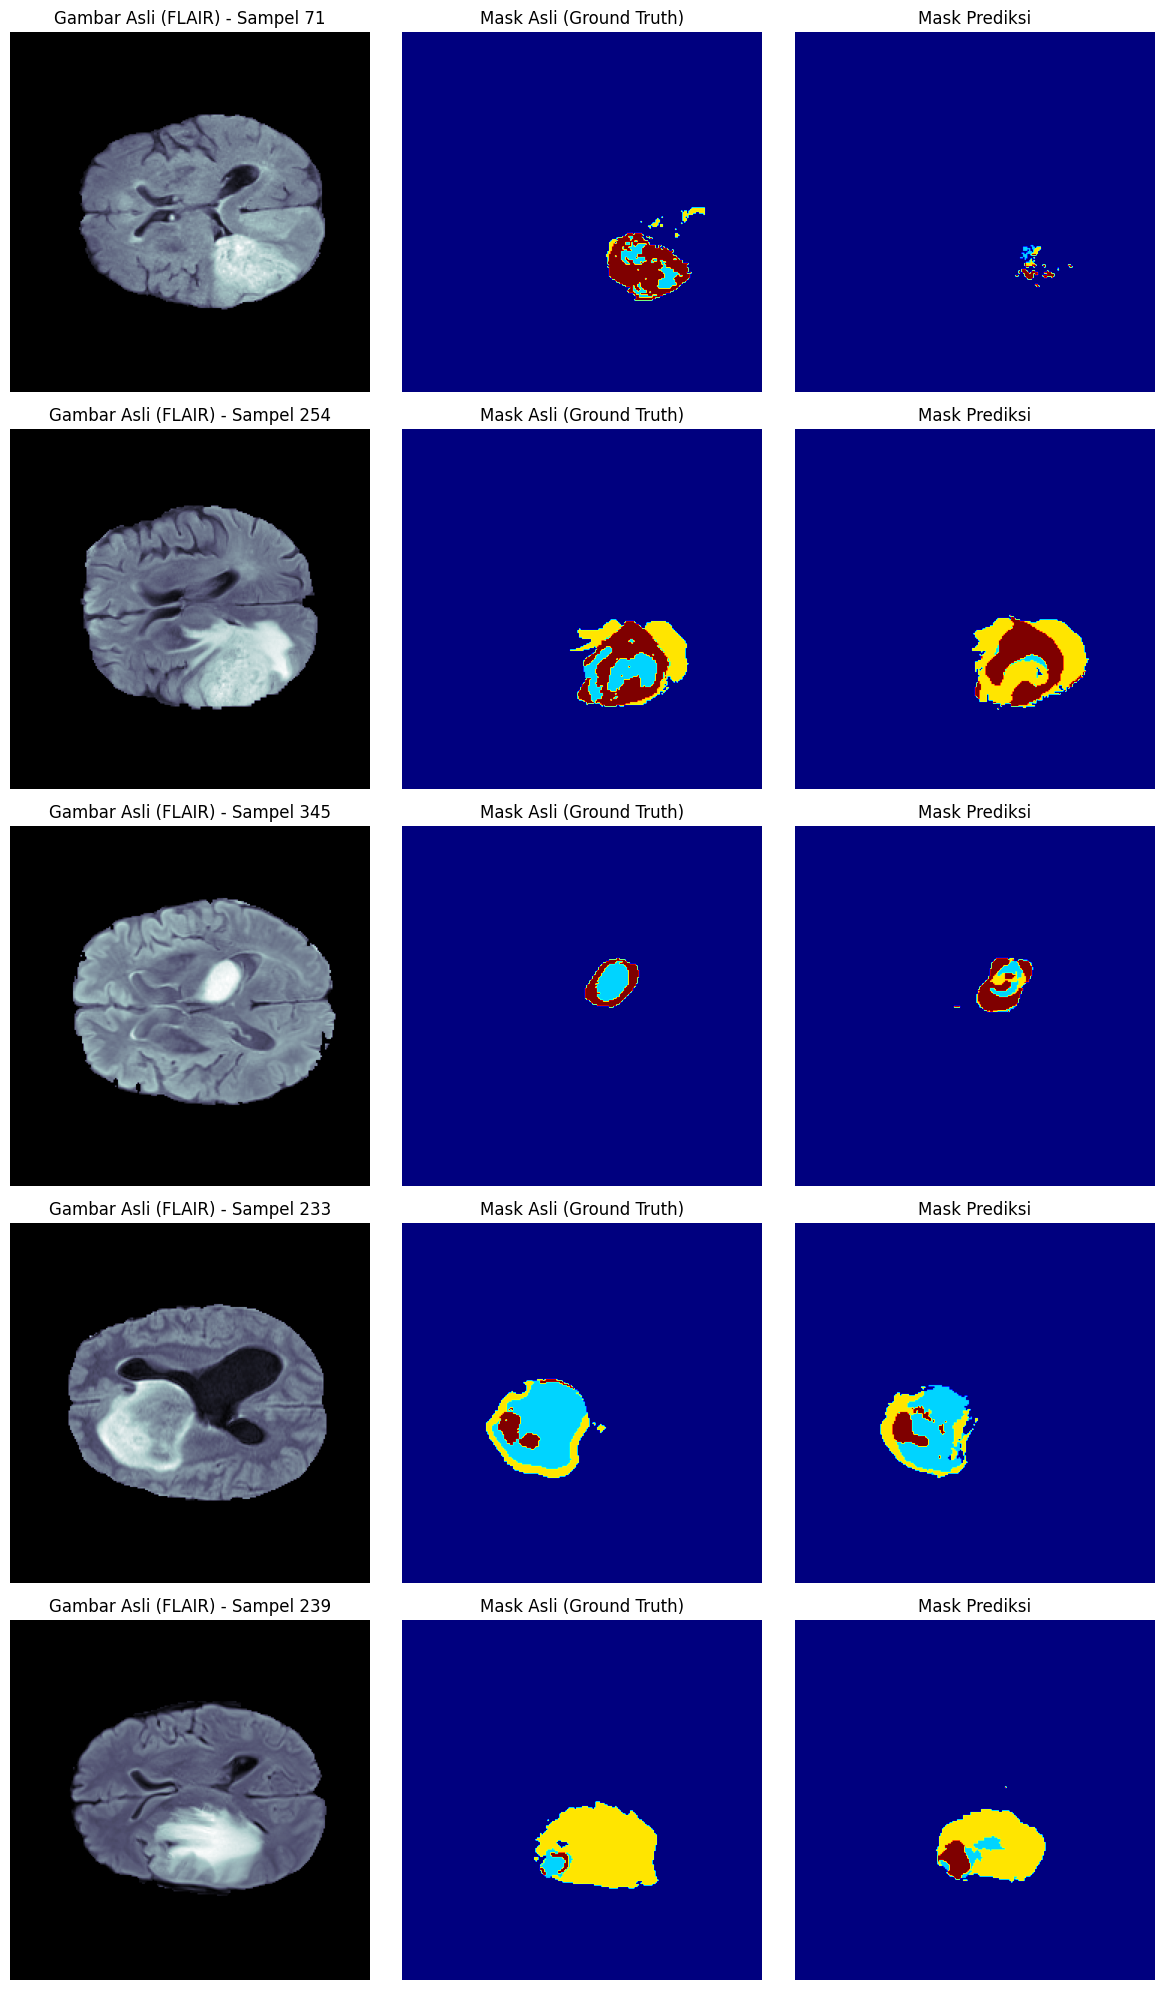

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))

    # Ambil sampel secara acak
    indices = np.random.choice(range(len(dataset)), num_samples, replace=False)

    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label = dataset[idx]

            # Tambahkan dimensi batch dan kirim ke device
            input_tensor = image.unsqueeze(0).to(device)

            # Prediksi
            output = model(input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            # Siapkan untuk plotting
            original_image = image[0].numpy() # Tampilkan channel pertama (FLAIR)
            true_mask = label.numpy()

            # Plotting
            axes[i, 0].imshow(original_image, cmap='bone')
            axes[i, 0].set_title(f"Gambar Asli (FLAIR) - Sampel {idx}")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(true_mask, cmap='jet')
            axes[i, 1].set_title("Mask Asli (Ground Truth)")
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred_mask, cmap='jet')
            axes[i, 2].set_title("Mask Prediksi")
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


visualize_predictions(model, full_dataset, DEVICE)